# Decode single and multiple gains

## Setup

In [3]:
import os
import subprocess

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "neurometry"))
print("Working directory: ", os.getcwd())

import warnings

warnings.filterwarnings("ignore")

import sys

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

Working directory:  /Volumes/GoogleDrive/My Drive/code/neurometry/neurometry
Directory added to path:  /Volumes/GoogleDrive/My Drive/code/neurometry
Directory added to path:  /Volumes/GoogleDrive/My Drive/code/neurometry/neurometry


## Imports

In [7]:
%load_ext autoreload
%autoreload 2

import json

import default_config as config
import matplotlib.pyplot as plt
import numpy as np
import torch
import train

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Single Gain experiments (e.g., experiment # 34)

In [8]:
CONFIG_DIR = os.path.join(os.getcwd(), "results", "configs")

print(f"Config in directory: {CONFIG_DIR}:")
for config_file in os.listdir(CONFIG_DIR):
    print(config_file)

Config in directory: /Volumes/GoogleDrive/My Drive/code/neurometry/neurometry/results/configs:
2022-12-30 14:51:00_s1_synthetic_run_f6lf1kqb.json
2022-12-30 14:51:00_s1_synthetic_run_moqyd9pq.json
2022-12-30 14:51:00_s1_synthetic_run_zpuaxz74.json
2022-12-30 14:51:00_s1_synthetic_run_9as5jt1n.json
2022-12-30 14:51:00_s1_synthetic_run_pnxol6cm.json
2022-12-30 14:51:00_s1_synthetic_run_yqj4d821.json
2022-12-30 14:51:00_s1_synthetic_run_t6esqyz7.json
2022-12-30 14:51:00_s1_synthetic_run_exe5ao7e.json
2022-12-30 14:51:00_s1_synthetic_run_7161z7gq.json
2022-12-30 14:51:00_s1_synthetic_run_rig5rbxv.json
2022-12-30 14:51:00_experimental_41_gain_1_run_nnl6pw1z.json
2022-12-30 14:51:00_experimental_41_gain_1_run_u91lhsuk.json
2022-12-30 14:51:00_experimental_41_gain_1_run_k1q4zzp7.json
2022-12-30 14:51:00_experimental_41_gain_1_run_nxnsx6xb.json
2022-12-30 14:51:00_experimental_41_gain_1_run_ntjvi3kj.json


In [9]:
with open(
    os.path.join(
        CONFIG_DIR, "2022-12-30 14:51:00_experimental_41_gain_1_run_ntjvi3kj.json"
    ),
) as f:
    config_dict = json.load(f)


# Convert a dict into an object where attributes are accessed with "."
# This is needed for the utils.load() function
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.__dict__ = self


config = AttrDict(config_dict)
config

{'batch_size': 50,
 'decoder_depth': 3,
 'decoder_width': 4,
 'encoder_depth': 4,
 'encoder_width': 6,
 'lr': 0.0909932979491224,
 'dataset_name': 'experimental',
 'sweep_name': '2022-12-30 14:51:00_experimental_41_gain_1_sweep_4pg4beyj',
 'expt_id': '41',
 'timestep_microsec': 1000000,
 'smooth': True,
 'select_gain_1': True,
 'n_times': None,
 'embedding_dim': None,
 'distortion_amp': None,
 'noise_var': None,
 'manifold_dim': 1,
 'latent_dim': 2,
 'posterior_type': 'hyperspherical',
 'distortion_func': None,
 'n_wiggles': None,
 'radius': None,
 'major_radius': None,
 'minor_radius': None,
 'synthetic_rotation': None,
 'device': 'cpu',
 'log_interval': 20,
 'checkpt_interval': 20,
 'scheduler': False,
 'n_epochs': 2,
 'beta': 0.03,
 'gamma': 20,
 'sftbeta': 4.5,
 'gen_likelihood_type': 'gaussian',
 'gain': 1,
 'run_name': '2022-12-30 14:51:00_experimental_41_gain_1_run_ntjvi3kj',
 'results_prefix': '2022-12-30 14:51:00_experimental_41_gain_1_run_ntjvi3kj',
 'data_n_times': 99,
 'dat

In [67]:
dataset_torch, labels, train_loader, test_loader = load(config)
dataset_torch = dataset_torch.to(config.device)
_, data_dim = dataset_torch.shape

INFO: # - Found file at data/expt34_times_timestep1000000.txt! Loading...
INFO: # - Found file at data/expt34_place_cells_timestep1000000.npy! Loading...
INFO: # - Found file at data/expt34_labels_timestep1000000.txt! Loading...


      Unnamed: 0         times      angles  velocities  gains
0              0  3.625397e+08  125.815085   -0.104195    1.0
1              1  3.635397e+08  129.515412   13.455259    1.0
2              2  3.645397e+08  154.552048   30.988614    1.0
3              3  3.655397e+08  184.048601   27.353089    1.0
4              4  3.665397e+08  212.071814   28.240268    1.0
...          ...           ...         ...         ...    ...
2948        2948  3.310540e+09   37.660339    0.094720    1.0
2949        2949  3.311540e+09   38.190007    1.087265    1.0
2950        2950  3.312540e+09   38.595808   -1.100449    1.0
2951        2951  3.313540e+09   46.685671   16.660279    1.0
2952        2952  3.314540e+09   54.966355    1.060331    1.0

[2953 rows x 5 columns]
the dataset contains only one gain value
Dataset shape: (934, 40).


### Instantiate model, optimizer, scheduler

In [49]:
model = models.neural_vae.NeuralVAE(
    data_dim=data_dim,
    latent_dim=config.latent_dim,
    sftbeta=config.sftbeta,
    encoder_width=config.encoder_width,
    encoder_depth=config.encoder_depth,
    decoder_width=config.decoder_width,
    decoder_depth=config.decoder_depth,
    posterior_type=config.posterior_type,
).to(config.device)

optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate, amsgrad=True)
scheduler = None

### Train model

In [50]:
train_losses, test_losses, best_model = train.train_test(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    config=config,
)

Train Epoch: 1 [0/654 (0%)]	Loss: 0.953363
Train Epoch: 1 [400/654 (61%)]	Loss: 1.075938
====> Epoch: 1 Average loss: 1.0660
====> Test set loss: 1.0528
Train Epoch: 2 [0/654 (0%)]	Loss: 1.440717
Train Epoch: 2 [400/654 (61%)]	Loss: 0.780879
====> Epoch: 2 Average loss: 0.6681
====> Test set loss: 0.4060
Train Epoch: 3 [0/654 (0%)]	Loss: 0.620768
Train Epoch: 3 [400/654 (61%)]	Loss: 0.619710
====> Epoch: 3 Average loss: 0.3782
====> Test set loss: 0.3707
Train Epoch: 4 [0/654 (0%)]	Loss: 0.237979
Train Epoch: 4 [400/654 (61%)]	Loss: 0.370063
====> Epoch: 4 Average loss: 0.4175
====> Test set loss: 0.3791
Train Epoch: 5 [0/654 (0%)]	Loss: 0.266760
Train Epoch: 5 [400/654 (61%)]	Loss: 0.445640
====> Epoch: 5 Average loss: 0.3145
====> Test set loss: 0.3389
Train Epoch: 6 [0/654 (0%)]	Loss: 0.307482
Train Epoch: 6 [400/654 (61%)]	Loss: 0.800572
====> Epoch: 6 Average loss: 0.2819
====> Test set loss: 0.3357
Train Epoch: 7 [0/654 (0%)]	Loss: 0.281903
Train Epoch: 7 [400/654 (61%)]	Loss: 0.

### Evaluate on test data

In [60]:
real_angles = np.array(labels["angles"])[: round(0.7 * len(dataset_torch))]

In [61]:
best_model.eval()
z, _, _ = best_model(dataset_torch[: round(0.7 * len(dataset_torch))])
# z, _, _ = best_model(dataset_gain2[:round(0.8*len(dataset_gain2))])

estimated_angles = (torch.atan2(z[:, 1], z[:, 0]) + 2 * torch.pi) % (2 * torch.pi)
estimated_angles = (180 / np.pi) * estimated_angles.detach().cpu().numpy()
# estimated_angles = estimated_angles.detach().cpu().numpy()

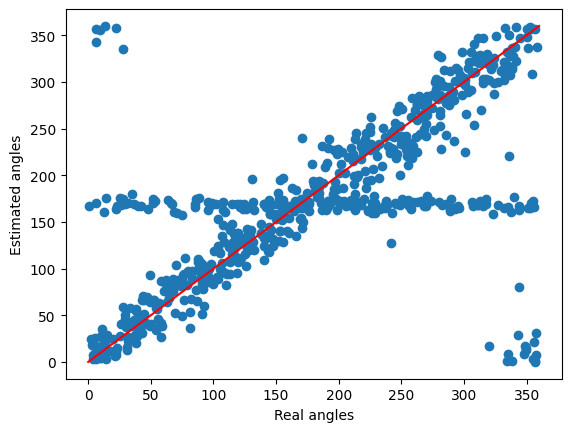

In [62]:
plt.scatter(real_angles, estimated_angles)
plt.xlabel("Real angles")
plt.ylabel("Estimated angles")
plt.plot([0, 360], [0, 360], color="red")

Text(0, 0.5, 'Loss')

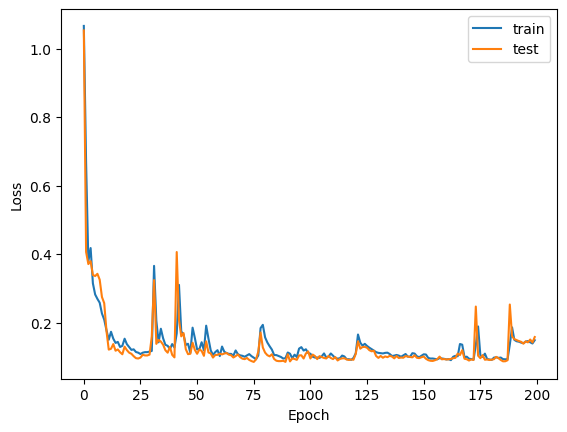

In [63]:
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Gain ramp experiments (G_initial + G_final)

In [ ]:
(
    dataset_gain1,
    labels_gain1,
    dataset_gain2,
    labels_gain2,
    train_loader_gain1,
    test_loader_gain1,
    train_loader_gain2,
    test_loader_gain2,
) = load(config)

dataset_gain1 = torch.from_numpy(dataset_gain1)
dataset_gain2 = torch.from_numpy(dataset_gain2)
dataset_gain1 = dataset_gain1.to(config.device)
dataset_gain2 = dataset_gain2.to(config.device)


_, data_dim = dataset_gain1.shape

### Instantiate model, optimizer, scheduler

In [46]:
model = models.neural_vae.NeuralVAE(
    data_dim=data_dim,
    latent_dim=config.latent_dim,
    sftbeta=config.sftbeta,
    encoder_width=config.encoder_width,
    encoder_depth=config.encoder_depth,
    decoder_width=config.decoder_width,
    decoder_depth=config.decoder_depth,
    posterior_type=config.posterior_type,
).to(config.device)

optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate, amsgrad=True)
scheduler = None

### Train Model

In [ ]:
train_losses, test_losses, best_model = train.train_test(
    model=model,
    train_loader=train_loader_gain1,
    test_loader=test_loader_gain1,
    optimizer=optimizer,
    scheduler=scheduler,
    config=config,
)

### Evaluate on test data
# TODO

In [ ]:
real_angles = np.array(labels["angles"])[round(0.7 * len(dataset_torch)) :]
# real_angles = np.array(labels_gain2["angles"])[:round(0.8*len(dataset_gain2))]

In [ ]:
best_model.eval()
z, _, _ = best_model(dataset_torch[round(0.7 * len(dataset_torch)) :])
# z, _, _ = best_model(dataset_gain2[:round(0.8*len(dataset_gain2))])

estimated_angles = (torch.atan2(z[:, 1], z[:, 0]) + 2 * torch.pi) % (2 * torch.pi)
# estimated_angles = (180 / np.pi) * estimated_angles.detach().cpu().numpy()
estimated_angles = estimated_angles.detach().cpu().numpy()

In [ ]:
plt.scatter(real_angles, estimated_angles)
plt.xlabel("Real angles")
plt.ylabel("Estimated angles")
plt.plot([0, 7], [0, 7], color="red")